In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading Dataset
[Dataset Link](https://www.kaggle.com/datasets/msambare/fer2013)

In [3]:
train_path = r'/kaggle/input/fer2013/train'
test_path = r'/kaggle/input/fer2013/test'
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(   # it is optimized for large dataset
    train_path,
    label_mode= 'categorical',
    color_mode= 'grayscale',
    class_names= CLASS_NAMES,
    shuffle= True,
    seed= 42,
    validation_split= 0.1,
    subset= 'both',
    batch_size= 8,    # using smaller batch size to prevent exceeding memory
    image_size= (48, 48)
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode= 'categorical',
    color_mode= 'grayscale',
    class_names= CLASS_NAMES,
    shuffle= True,
    seed= 42,
    batch_size= 8,
    image_size= (48, 48)
)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.


## Data Augmentation

In [5]:
# using this because it is GPU accelerated
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode= 'horizontal'),
    tf.keras.layers.RandomRotation(factor= (-0.1, 0.1)),    # [-10% * 2pi, 10% * 2pi]
    tf.keras.layers.RandomBrightness(factor= (-0.1, 0.1))   # only slightly darken or brighten the image
])


def augment_data(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, ...]:
    aug_img = data_augmentation(image)
    return aug_img, label


# generating augmented images
augmented_dataset = train_dataset.map(augment_data)

## Dataset Preparation

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .concatenate(augmented_dataset)    # concatenating both train and augmented datasets
    .shuffle(buffer_size= 100)         # shuffling so that one batch will have both augmented and normal images
    .prefetch(buffer_size= AUTOTUNE)   # prefetching to making training faster
)

## Data Visualization
Visualizing one batch of images.

(8, 48, 48, 1) (8, 7)


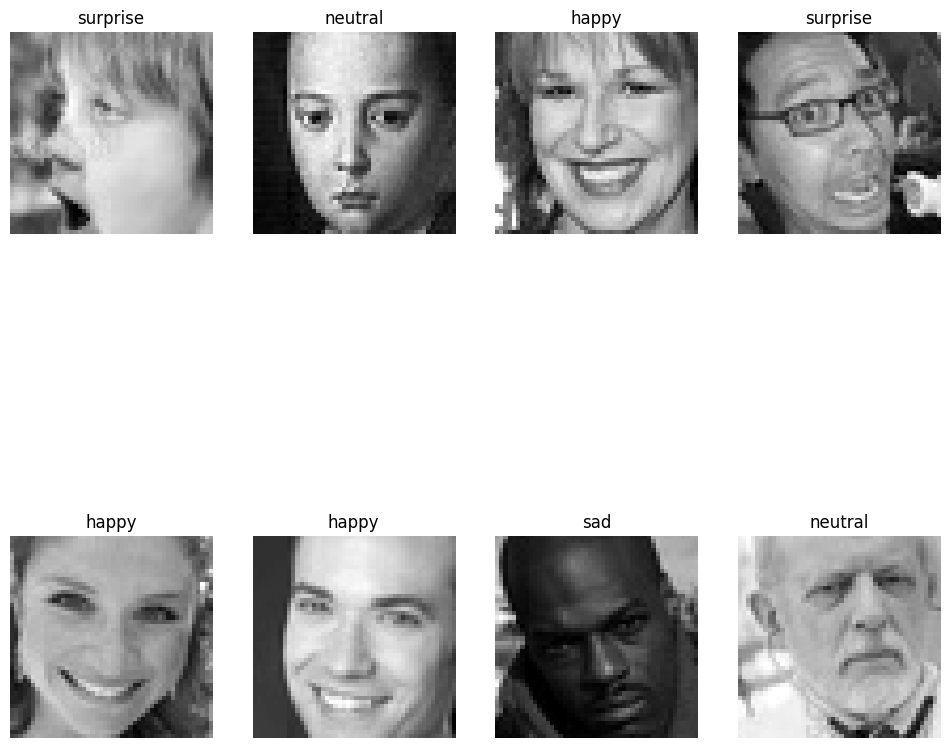

In [8]:
plt.figure(figsize= (12, 12))

for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)
    for index in range(8):
        plt.subplot(2, 4, index + 1)
        plt.imshow(images[index] / 255., interpolation= 'nearest', cmap= 'gray')
        plt.title(CLASS_NAMES[tf.argmax(labels[index])])
        plt.axis('off')

## VGGNet
[Visual Gemoetry Group](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

In [9]:
IMG_SIZE = 48

resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [10]:
def create_callbacks(name: str, *, es_patience: int = 20) -> list[tf.keras.callbacks.Callback]:
    tensorboard_cb = tf.keras.callbacks.TensorBoard(f'/kaggle/working/logs/{name}')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience= es_patience, 
        restore_best_weights= True
    )
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        f'{name}.weights.h5', 
        save_weights_only= True,
        save_best_only= True
    )
    return [tensorboard_cb, early_stopping, checkpoint_cb]

In [11]:
vgg16_model = tf.keras.Sequential([
    # input
    tf.keras.layers.Input(shape= (48, 48, 1)),
    resize_rescale,

    # first conv group
    tf.keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2), strides= (2, 2)),

    # second conv group
    tf.keras.layers.Conv2D(filters= 128, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 128, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2), strides= (2, 2)),

    # third conv group
    tf.keras.layers.Conv2D(filters= 256, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 256, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 256, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2), strides= (2, 2)),

    # forth conv group
    tf.keras.layers.Conv2D(filters= 512, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 512, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 512, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2), strides= (2, 2)),

    # fifth conv group
    tf.keras.layers.Conv2D(filters= 512, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 512, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Conv2D(filters= 512, kernel_size= (3, 3), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2), strides= (2, 2)),

    # dense network
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation= 'relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.Dropout(0.5),

    # output
    tf.keras.layers.Dense(7, activation= 'softmax')
])

In [12]:
vgg16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,630,663 (128.29 MB)

 Trainable params: 33,627,719 (128.28 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [13]:
vgg16_model.compile(
    loss= 'categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4), # using smaller learning rate to prevent vanishing/exploading gradients
    metrics= ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(name= 'top_k_acc')]
)

In [14]:
history = vgg16_model.fit(
    train_dataset,
    epochs= 100,
    validation_data= validation_dataset,
    callbacks= create_callbacks('vgg_16_model_data_aug')
)

Epoch 1/100
6460/6460 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.2589 - loss: 2.2646 - top_k_acc: 0.8856 - val_accuracy: 0.4310 - val_loss: 1.4527 - val_top_k_acc: 0.9505
Epoch 2/100
6460/6460 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - accuracy: 0.4530 - loss: 1.4119 - top_k_acc: 0.9606 - val_accuracy: 0.5098 - val_loss: 1.2436 - val_top_k_acc: 0.9735
Epoch 3/100
6460/6460 ━━━━━━━━━━━━━━━━━━━━ 136s 21ms/step - accuracy: 0.5323 - loss: 1.2380 - top_k_acc: 0.9729 - val_accuracy: 0.5122 - val_loss: 1.2503 - val_top_k_acc: 0.9697
Epoch 4/100
6460/6460 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - accuracy: 0.5777 - loss: 1.1245 - top_k_acc: 0.9796 - val_accuracy: 0.5707 - val_loss: 1.1318 - val_top_k_acc: 0.9819
Epoch 5/100
6460/6460 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - accuracy: 0.6161 - loss: 1.0291 - top_k_acc: 0.9848 - val_accuracy: 0.5819 - val_loss: 1.0940 - val_top_k_acc: 0.9822
Epoch 6/100
6460/6460 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - accuracy: 0.6540 - loss: 0.9281 - top_k_acc: 0.988

In [15]:
test_loss, test_acc, top_k = vgg16_model.evaluate(test_dataset)
print(f'{test_acc = :.2%}\n{test_loss = }\n{top_k = :.2%}')

898/898 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6388 - loss: 1.0008 - top_k_acc: 0.9845
test_acc = 64.18%
test_loss = 0.9895809292793274
top_k = 98.50%


In [16]:
# zipping working directory to download the model and logs on my system

import subprocess

subprocess.run(["zip", "-r", "working_dir.zip", "/kaggle/working"], stdout= subprocess.DEVNULL)

CompletedProcess(args=['zip', '-r', 'working_dir.zip', '/kaggle/working'], returncode=0)

## ResNet 
- [ResNet Paper link](https://arxiv.org/abs/1512.03385)
- [GFG - Residual Networks (ResNet) – Deep Learning](https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/)

In [ ]:
# creating my own residual unit for ResNet-34 architecture
class ResidualUnit(tf.keras.Layer):
    def __init__(
        self, 
        filters: int,
        *,
        strides: int = 1,
        activation: str = 'relu',
        **kwargs
    ) -> None:
        # calling parent constructor
        super().__init__(**kwargs)
        
        # getting activation function
        self.activation = tf.keras.activations.get(activation)

        # default kwargs for Conv2D
        default_kwargs = {
            'filters': filters,
            'padding': 'same',
            'kernel_initializer': 'he_normal',
            'use_bias': False
        }

        # Describing main convolutional layers of RU, C1 -> BN + ReLU -> C2 -> BN
        self.main_layers = [
            tf.keras.layers.Conv2D(**default_kwargs, strides= strides, kernel_size= 3),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(**default_kwargs, kernel_size= 3),
            tf.keras.layers.BatchNormalization()
        ]

        # we only have to add skip layer if stride is greater than 1
        self.skip_layers = []
        
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(**default_kwargs, strides= strides, kernel_size= 1),
                tf.keras.layers.BatchNormalization()
            ]

    
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        # creating RU using Funtional API of Keras
        Z = inputs
        # F(Z) = H(Z) - Z
        for layer in self.main_layers:
            Z = layer(Z)

        # Skip Connections
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        # H(Z) = F(Z) + Z
        return self.activation(Z + skip_Z)